In [1]:
import os
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt 
import re
import numpy as np 
import seaborn as sns
import json
#os.getcwd() #get current working directory

'c:\\Users\\kkami\\Desktop'

In [2]:
#os.chdir("C://users//kkami//desktop") #change to appropriate local directory

In [3]:
email = pd.read_csv('email_data.csv', header = 0, delimiter = ',') #import datasets
activity = pd.read_csv('activity_data.csv', header = 0, delimiter = ',')

# #1 How many rows are in the two datasets? Print results segmented with commas.

In [4]:
email_rows = "{:,}".format(email.shape[0])
activity_rows = "{:,}".format(activity.shape[0])

print(f'Rows in email dataset: {email_rows}.') 
print(f'Rows in activity dataset:{activity_rows}.') 

Rows in email dataset: 474,163.
Rows in activity dataset:4,559,973.


In [5]:
print(f'Total number of emails sent: {"{:,}".format(int(email.shape[0]/0.03))}.') #gives the total number of emails sent, given the referenced email dataset is comporised of only 3% of the overall emails sent. COnsider rounding down to a whole integer value.

Total number of emails sent: 15,805,433.


# #2 Earliest and most recent email dates in Pacific Standard Time Zone.  Print result in mm/dd/yyy hour:minute 24 hour format.

In [6]:
#Email timestampes are of 'Object' datatypes as well as 'UTC' format and will need to be localized and converted to US/Pacific time zones for analysis. 

time_cols = ['EmailSentDateTimeUtc', 'EmailOpenedDateTimeUtc', 'EmailClickedDateTimeUtc'] #obtain columns that hold timestamp strings to be converted and analyzed
string_cols = ['LogId', 'EmailCampaignId', 'UserId', 'ZipCode', 'AddressData']

def pac_time(df, column): #create function to avoild repeatedly calling timestamp functions
    df[column] = df[column].astype(str)
    df[column] = df[column].apply(str.strip)
    df[column] = pd.to_datetime(df[column]) #convert column to a pandas datetime object
    df[column] = df[column].dt.tz_localize('UTC') #convert pandas datetime object to a 'UTC' time signature
    df[column] = df[column].dt.tz_convert('US/Pacific') #convert 'UTC' time to 'US/Pacific' time zone
    df.rename(columns = {column:column.replace('Utc', 'PST')}, inplace = True) #rename columns that intiially contained 'UTC' terms to 'PST' terms


def to_string(df, column):
    df[column] = df[column].astype(str)


In [7]:
email.dtypes
#observe the column datatypes, the int and float values will require conversion to strings to be addressed as categorical values, the timestamp columns require change to to datetime objects of PST time zone

LogId                        int64
EmailSentDateTimeUtc        object
EmailCampaignId              int64
EmailOpenedDateTimeUtc      object
EmailClickedDateTimeUtc     object
UserId                       int64
ZipCode                    float64
AddressData                 object
dtype: object

In [8]:
email.isnull().sum() #no missing email IDs, campaign IDs, Users, or address information

LogId                           0
EmailSentDateTimeUtc            0
EmailCampaignId                 0
EmailOpenedDateTimeUtc     334341
EmailClickedDateTimeUtc    450912
UserId                          0
ZipCode                    152113
AddressData                 76231
dtype: int64

In [9]:
for column in time_cols: #apply timestamp modifications to each of the time columns in the emails dataset
    pac_time(email, column)

for column in string_cols: #convert remaining columns to strings to act as categorical variables
    to_string(email, column)

In [10]:
email.dtypes #confirm the datatypes are in line with expected values

LogId                                          object
EmailSentDateTimePST       datetime64[ns, US/Pacific]
EmailCampaignId                                object
EmailOpenedDateTimePST     datetime64[ns, US/Pacific]
EmailClickedDateTimePST    datetime64[ns, US/Pacific]
UserId                                         object
ZipCode                                        object
AddressData                                    object
dtype: object

In [11]:
earliest_email = email['EmailSentDateTimePST'].min().strftime('%m/%d/%Y %H:%M')
print(f'Earliest email in the log: {earliest_email}.') #The earliest listed timestamp in 24 hour time format

Earliest email in the log: 01/03/2018 20:29.


In [12]:
most_recent_email = email['EmailSentDateTimePST'].max().strftime('%m/%d/%Y %H:%M') #The most recent listed timestamp in 24 hour time format
print(f'Most recelt email in the log: {most_recent_email}.') #The earliest listed timestamp in 24 hour time format

Most recelt email in the log: 04/19/2021 06:45.


# #3 Which 10 zip codes receive the most emails and how many emails do they receive?

In [13]:
email['ZipCode'].value_counts() #Get count values for zip codes, however noting the potential errors in formatting

nan        152113
63301.0       312
33801.0       310
34210.0       299
38301.0       295
            ...  
97874.0         1
45220.0         1
89883.0         1
72937.0         1
15104.0         1
Name: ZipCode, Length: 14305, dtype: int64

In [14]:
email['ZipCode'] = email['ZipCode'].str.replace('\.0', '', regex=True) #remove '.0' characters from end of zips

In [15]:
email[(~email['ZipCode'].str.isalpha()) & (email['ZipCode'].str.len() != 5)].head(3) #use alpha to get characters that are not 'nan' strings, also check for values that are not 5 digits in length (likely errors)
#also note that the zips json strings appear to have potentially corrective zip code data.

,LogId,EmailSentDateTimePST,EmailCampaignId,EmailOpenedDateTimePST,EmailClickedDateTimePST,UserId,ZipCode,AddressData
661,756484860789,2020-04-13 08:15:09.130000-07:00,653571247008,NaT,NaT,745541520548,6511,"{'DataType':'Address','ZipCode':'06511'}"
662,536605770972,2020-10-13 21:45:05.943000-07:00,653571247008,NaT,NaT,745541520548,6511,"{'DataType':'Address','Code':'1D9B4C64-7AF7-46..."
663,328279018442,2019-02-24 16:01:03.830000-08:00,653571247008,NaT,NaT,745541520548,6511,"{'DataType':'Address','ZipCode':'06511'}"


In [16]:
email['AddressData'] = email['AddressData'].str.replace("'", '"') #replace single quotes with double quotes in order to get appropriate formatting to use json library methods
address_index = email[email['AddressData'] != 'nan'].index #get the indices that contain address data in order to use json methods
email['parse'] = email.iloc[address_index]['AddressData'].apply(json.loads) #create new column that will convert the string values held in AddressData to json objects that can be extracted
email['Zips'] = '' #create empty Zips column that will hold the extracted zip code information from the parsed json objects

In [17]:
email.loc[address_index, 'AddressData'] = email.loc[address_index, 'AddressData'].apply(json.loads) #convert strings to json type dictionary to extract the zip code information

In [18]:
def getAddress(dictionary): #create function to extract the zip code information
    return dictionary.get('ZipCode')

def keepZip(zipCode): #create function to remove any alpha prefixes/suffixes from the extracted zip code
    return re.sub('[a-zA-Z]*', '', zipCode)

In [19]:
#The following lines all related to obtaining the zip code information from the json objects and placeing them in a new column with the proper formatting

email.loc[address_index, 'Zips'] = email.loc[address_index, 'AddressData'].apply(getAddress) #extract zipcode information from json object, and place into Zips column

email['Zips'] = email['Zips'].apply(keepZip) #remove alpha characters from extracted zipcodes

email[(email['Zips'].str.len() !=5) & (email['Zips'] != 'nan')]['Zips'].value_counts() #observe value counts of zipcodes that do not follow typical 5 digit notation

email['Zips'] = email['Zips'].str.strip() #apply strip to remove any potential whitespace from the zipcode strings as two of the counts appear to have 5 digits and must contain some whitespace characters

email[(email['Zips'].str.len() !=5) & (email['Zips'] != 'nan')]['Zips'].value_counts() #whitespaces removed, shows two values remaining that contain '.' to be removed

email['Zips'] = email['Zips'].str.replace('.', '') #remove periods from zipcode numbers

In [20]:
email[(email['Zips'].str.len() !=5) & (email['Zips'] != 'nan')]['Zips'].value_counts() #check value counts to see if zip codes are all digits and follow 5 digit format
#all values conform to this format, the remaining values (count 152113) are blank values

    152113
Name: Zips, dtype: int64

In [21]:
email[(email['Zips'].str.len() != 5) & (email['Zips'] != '')] #confirm all rows with values hold elements that are 5 digits in length

,LogId,EmailSentDateTimePST,EmailCampaignId,EmailOpenedDateTimePST,EmailClickedDateTimePST,UserId,ZipCode,AddressData,parse,Zips


In [22]:
email[(~email['Zips'].str.isdigit()) & (email['Zips'] != '')] #confirm that all rows with values are digits (no alpha characters)

,LogId,EmailSentDateTimePST,EmailCampaignId,EmailOpenedDateTimePST,EmailClickedDateTimePST,UserId,ZipCode,AddressData,parse,Zips


In [23]:
email['ZipCode'] = email['ZipCode'].replace('nan', '') #rreplace the nan string with blank values in order to compare to the zipcode values from the 'ZipCode' column

In [24]:
email[email['ZipCode'] != email['Zips']].shape[0] #Comparing the zipcode column with the Zips column finds 17,000+ values that don't match. Replace the values in ZipCode that do not follow the appropriate zip format with those in Zips


17181

In [25]:
email[(email['ZipCode'].str.len() != 5) & (email['ZipCode'] != '')].ZipCode.apply(len).unique() #finds the unique lengths in ZipCode that are not of length 5 and not blank

array([4, 3, 1], dtype=int64)

In [26]:
email[(email['ZipCode'].str.len() ==3) & (email['ZipCode'] != '')][['ZipCode', 'Zips']] #observe those rows of length 3 and compare to the value in Zips

,ZipCode,Zips
46032,725,00725
46033,725,00725
46034,725,00725
46035,725,00725
46036,725,00725
...,...,...
470996,690,00690
470997,690,00690
471352,690,00690
471353,690,00690


In [27]:
email[(email['ZipCode'].str.len() ==4) & (email['ZipCode'] != '')][['ZipCode', 'Zips']]  #observe those rows of length 4 and compare to the value in Zips

,ZipCode,Zips
661,6511,06511
662,6511,06511
663,6511,06511
664,6511,06511
665,6511,06511
...,...,...
473914,3848,03848
473925,7205,07205
473926,7205,07205
474086,2370,02370


In [28]:
email[(email['ZipCode'].str.len() ==1) & (email['ZipCode'] != '')][['ZipCode', 'Zips']]  #observe those rows of length 1 and compare to the value in Zips

,ZipCode,Zips
273872,0,00000


In [29]:
email.loc[273872, 'ZipCode'] = '' #remove the value of 0 in the ZipCode column
email.loc[273872, 'Zips'] = '' #remove the value of 00000 as it's invalid in the Zips column

In [30]:
email[(email['ZipCode'].str.len() == 1) & (email['ZipCode'] != '')] #confirm that all ZipCode values are appropriate format

,LogId,EmailSentDateTimePST,EmailCampaignId,EmailOpenedDateTimePST,EmailClickedDateTimePST,UserId,ZipCode,AddressData,parse,Zips


In [31]:
change_index = email[email['Zips'] != email['ZipCode']].index #grab all the indices that do not match and need correction
email.loc[change_index, 'ZipCode'] = email.loc[change_index, 'Zips'] #update the zipcode column with the correct zip code values
email[email['Zips'] != email['ZipCode']] #confirm that all values now match

,LogId,EmailSentDateTimePST,EmailCampaignId,EmailOpenedDateTimePST,EmailClickedDateTimePST,UserId,ZipCode,AddressData,parse,Zips


In [32]:
top_zips = email['ZipCode'].value_counts()[0:11] #get top 10 zip codes and the emails sent to each one
top_zips

         152114
63301       312
33801       310
34210       299
38301       295
67460       285
95971       277
42301       266
36104       254
40769       234
85225       229
Name: ZipCode, dtype: int64

# #3 Summary:

The list above highlights the top 10 zip codes that recieve emails from FieldLevel.  No apparently new information was gained from inclusion of the zip codes in json format,
however helps to make for clean data and understanding for future applications.  Note that while the above zip codes highlight the most frequent zip codes, the vast majority 
of zip code information holds null values (150k+), and the most frequent list would likely not generalize well in assuming these zip codes are equally distributed across the population. 

# #4 Plot two lines on a single graph
A) Total distinct users who were sent at least 1 email by month and year.
    
B) The monthly percentage of users who were sent an email and were active the same day

In [33]:
year_month = email.groupby([email['EmailSentDateTimePST'].dt.year, email['EmailSentDateTimePST'].dt.month]).agg({'UserId':'nunique'}) #get the distinct number of users that were sent an email ()
#month_year = email.groupby([email['EmailSentDateTimePST'].dt.month, email['EmailSentDateTimePST'].dt.year]).agg({'UserId':'nunique'}) #commented out but retained in case the month/year metric is actually desired
year_month.head()

UserId
EmailSentDateTimePST EmailSentDateTimePST        
2018                 1                        456
                     2                        559
                     3                        490
                     4                        508
                     5                       1223

In [34]:
#month_year.index = month_year.index.rename(['Month', 'Year'])
year_month.index = year_month.index.rename(['Year', 'Month']) #rename the indices to manipulate as strings in future steps

In [35]:
year_month = year_month.reset_index() #reset the index in order to manipulate as strings and apply as the x-axis in the final plot
#month_year = month_year.reset_index()

year_month = year_month.astype(str) #convert to strings
#month_year = month_year.astype(str)

year_month.rename(columns = {'UserId':'UserCount'}, inplace=True) #rename columns to more applicable titles
#month_year.rename(columns = {'UserId':'UserCount'}, inplace=True)

year_month['UserCount'] = year_month['UserCount'].astype(int) #convert counts of users back to integers in order to plot 
#month_year['UserCount'] = month_year['UserCount'].astype(int)

In [36]:
#month_year['Date'] = month_year['Month'] + '-' + month_year['Year']
year_month['Date'] = year_month['Month'] + '-' + year_month['Year'] #join columns to act as x-axis in the final plot

In [37]:
year_month.head() #view current dataframe of year_month

,Year,Month,UserCount,Date
0,2018,1,456,1-2018
1,2018,2,559,2-2018
2,2018,3,490,3-2018
3,2018,4,508,4-2018
4,2018,5,1223,5-2018


In [38]:
email_dates = email.copy() #create new dataframe of emails to modify and avoid disturbing original dataframe

In [39]:
#the monthly percentage of users who were sent an email and were active the same day

email_dates['EmailSentDateTimePST'] = email_dates['EmailSentDateTimePST'].dt.date
email_dates.head() #confirm date format in sent date column

,LogId,EmailSentDateTimePST,EmailCampaignId,EmailOpenedDateTimePST,EmailClickedDateTimePST,UserId,ZipCode,AddressData,parse,Zips
0,208728980120,2019-07-31,792229022220,NaT,NaT,851332105693,,nan,NaN,
1,292563123584,2019-08-01,866429603262,2019-08-02 08:16:01.753333300-07:00,NaT,369293054977,,nan,NaN,
2,72552047640,2019-08-07,383130475294,NaT,NaT,938684493058,,nan,NaN,
3,1089121462891,2019-08-07,792229022220,NaT,NaT,50233193142,,nan,NaN,
4,828770719378,2019-08-12,479810600058,NaT,NaT,369293054977,,nan,NaN,


In [40]:
user_dates = email_dates[['EmailSentDateTimePST', 'UserId']] #create subset of data to easier manipulate and understand data

In [41]:
active_dates = activity[['UserId', 'DateOfActivityPST']] #create new subset of data to easier manipulate and understand data

In [42]:
user_dates = user_dates.astype(str)#convert items to strings in order to join dataframes
active_dates = active_dates.astype(str) #convert items to strings in order to join dataframes


user_dates['UserId'] = user_dates['UserId'].str.strip() #remove whitespace to avoid join errors
active_dates['UserId'] = active_dates['UserId'].str.strip()

In [43]:
grouped_dates = pd.merge(user_dates, active_dates, left_on = ['UserId', 'EmailSentDateTimePST'], right_on = ['UserId', 'DateOfActivityPST'], how = "left") #left join the sent/user dataset with the active dates of the activity set. Rows in the 'DateOfActivityPST' column bearing NULL values denote no activity logged for the given day.
grouped_dates #observe format of grouped dataframe, observing null values vs. email sent dates

,EmailSentDateTimePST,UserId,DateOfActivityPST
0,2019-07-31,851332105693,NaN
1,2019-08-01,369293054977,NaN
2,2019-08-07,938684493058,NaN
3,2019-08-07,50233193142,NaN
4,2019-08-12,369293054977,NaN
...,...,...,...
474158,2021-04-07,155726404619,NaN
474159,2021-04-08,906354699455,NaN
474160,2021-04-01,772106964664,2021-04-01
474161,2021-04-04,944437414453,2021-04-04


In [44]:
grouped_dates['EmailSentDateTimePST'] = pd.to_datetime(grouped_dates['EmailSentDateTimePST']) #convert date columns back to dates in order to parse out and group by month
grouped_dates['DateOfActivityPST'] = pd.to_datetime(grouped_dates['DateOfActivityPST'])

In [45]:
date_counts = grouped_dates.groupby([grouped_dates['EmailSentDateTimePST'].dt.year, grouped_dates['EmailSentDateTimePST'].dt.month]).count() #obtain counts of emails sent and pings of activity for each day
date_counts.head()

EmailSentDateTimePST  UserId  \
EmailSentDateTimePST EmailSentDateTimePST                                 
2018                 1                                      535     535   
                     2                                      677     677   
                     3                                      576     576   
                     4                                      604     604   
                     5                                     1399    1399   

                                           DateOfActivityPST  
EmailSentDateTimePST EmailSentDateTimePST                     
2018                 1                                   248  
                     2                                   334  
                     3                                   280  
                     4                                   283  
                     5                                   431

In [46]:
date_counts = date_counts.rename(columns = {'EmailSentDateTimePST':'EmailSentCount', 'DateOfActivityPST':'ActivityCount'}) #rename columns to better reflect the column contents
date_counts.index = date_counts.index.rename(['Year', 'Month']) #rename the index to better reflect the index contents, additionally in order to join as strings together in the next steps

In [47]:
date_counts.head() #confirm changes to columns / index

EmailSentCount  UserId  ActivityCount
Year Month                                       
2018 1                 535     535            248
     2                 677     677            334
     3                 576     576            280
     4                 604     604            283
     5                1399    1399            431

In [48]:
date_counts['Active Users (%)'] = (date_counts['ActivityCount']) / (date_counts['EmailSentCount']) * 100 #create % active users column from sent and activity counts
date_counts.head()

EmailSentCount  UserId  ActivityCount  Active Users (%)
Year Month                                                         
2018 1                 535     535            248         46.355140
     2                 677     677            334         49.335303
     3                 576     576            280         48.611111
     4                 604     604            283         46.854305
     5                1399    1399            431         30.807720

In [49]:
date_counts = date_counts.reset_index(inplace = False) #reset index in order to easier use as x-axis for plotting (instead of working with MultiIndex) 
date_counts.head()

,Year,Month,EmailSentCount,UserId,ActivityCount,Active Users (%)
0,2018,1,535,535,248,46.355140
1,2018,2,677,677,334,49.335303
2,2018,3,576,576,280,48.611111
3,2018,4,604,604,283,46.854305
4,2018,5,1399,1399,431,30.807720


In [50]:
date_counts['Year'] = date_counts['Year'].astype(str) #convert to string to manipulate columns
date_counts['Month'] = date_counts['Month'].astype(str)
date_counts['Date'] = date_counts['Year'] + '-' + date_counts['Month'] #create new Date column to use as x-axis in plot

In [51]:
date_counts.head() #view final dataset 

,Year,Month,EmailSentCount,UserId,ActivityCount,Active Users (%),Date
0,2018,1,535,535,248,46.355140,2018-1
1,2018,2,677,677,334,49.335303,2018-2
2,2018,3,576,576,280,48.611111,2018-3
3,2018,4,604,604,283,46.854305,2018-4
4,2018,5,1399,1399,431,30.807720,2018-5


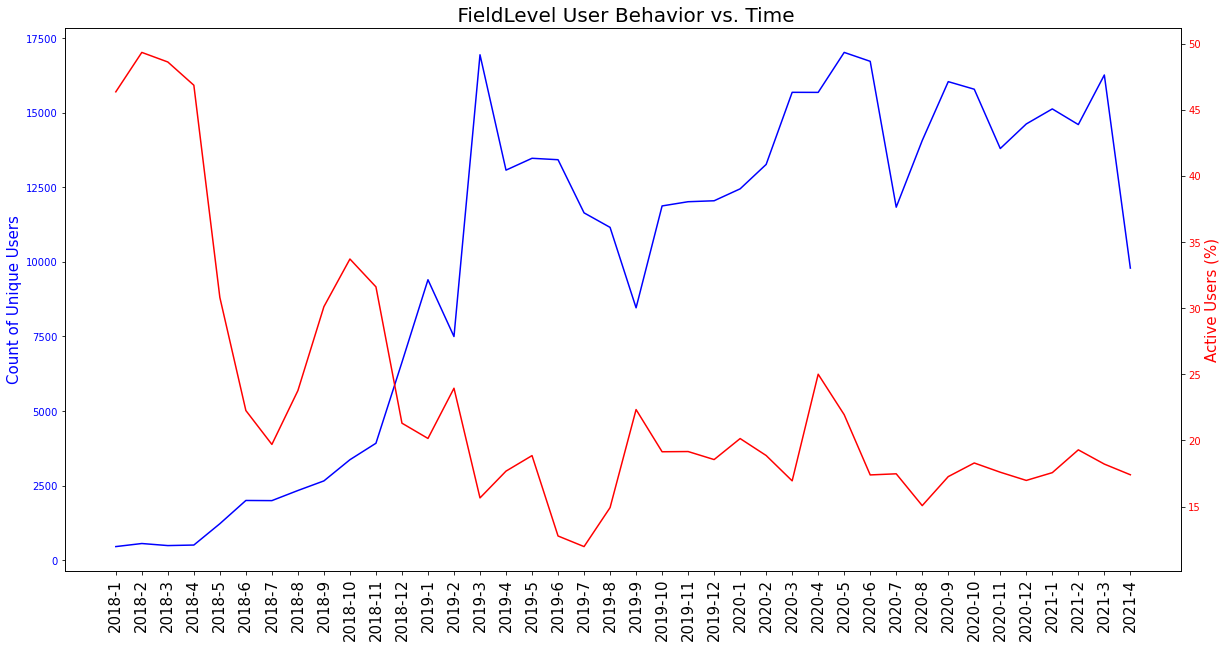

In [52]:
#plot the final graphs per request
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots()
ax.plot(year_month['Date'], year_month['UserCount'], color = 'b')
ax.tick_params(axis = 'y', labelcolor = 'b')
ax.set_xticklabels(year_month['Date'], rotation = 90, fontsize= 15)
ax.set_ylabel('Count of Unique Users', fontsize = 15, color = 'b')

ax2 = ax.twinx()

ax2.plot(date_counts['Date'], date_counts['Active Users (%)'], color = 'r')
ax2.tick_params(axis = 'y', labelcolor = 'r')
ax2.set_ylabel('Active Users (%)', fontsize = 15, color = 'r')
plt.title(' FieldLevel User Behavior vs. Time', fontsize = 20)
plt.show()

# #4 Summary: 
Unique users have steadily increased in count, up ~3800% (248 to 9791) across the dataset. This could indicate successful marketing 
efforts and strategies that are engaging athletes to consider using FieldLevel, however does not provide evidence that they are remaining 
engaged over time.  Users who recieve emails are increasingly less likely to be active the same day (down 46% to 17%) indicating the 
potential that email are less effective than they were initially, or that the athlete pool was significantly smaller at the outset 
of the data's timeline, and potentially skewed results in a positive direction.  

# #5 Determination of broken links, and the likelihood users are exposed to them multiple times 

In [53]:
email_links = email.copy() #create new copies of dataframes to avoid making slices on copies of dataframes
active_log = activity.copy()

In [54]:
#convert dates to datetime objects for manipulation and joining
email_links['EmailSentDateTimePST'] = email_links['EmailSentDateTimePST'].dt.date 
email_links['EmailOpenedDateTimePST'] = email_links['EmailOpenedDateTimePST'].dt.date
email_links['EmailClickedDateTimePST'] = email_links['EmailClickedDateTimePST'].dt.date


In [55]:
email_links = email_links[(email_links['EmailSentDateTimePST'].notnull()) & (email_links['EmailClickedDateTimePST'].notnull())][['UserId', 'EmailCampaignId', 'EmailClickedDateTimePST']]   #find all emails that saw activity on the same day
email_links.head()

,UserId,EmailCampaignId,EmailClickedDateTimePST
23,57254519310,461658501013,2020-04-13
34,985691563630,946235214960,2019-06-19
46,1076785502778,839979203061,2018-09-29
64,59945322238,946235214960,2020-02-04
78,88068707950,839979203061,2020-06-14


In [56]:
email_links = email_links.astype(str) #convert dates to strings in order to perform manipulation

for column in email_links.columns:
    email_links[column] = email_links[column].apply(str.strip) #remove whitespace on string

active_log = active_log.astype(str) #convert dates to strings in order to perform manipulation

for column in active_log.columns:
    active_log[column] = active_log[column].apply(str.strip)#remove whitespace on string

In [57]:
email_active = pd.merge(email_links, active_log, left_on = ['UserId', 'EmailClickedDateTimePST'], right_on = ['UserId', 'DateOfActivityPST'], how = "left")[['UserId', 'EmailCampaignId', 'EmailClickedDateTimePST', 'DateOfActivityPST']]
email_active.head() #obtain a list of emails that have potentially broken links

,UserId,EmailCampaignId,EmailClickedDateTimePST,DateOfActivityPST
0,57254519310,461658501013,2020-04-13,NaN
1,985691563630,946235214960,2019-06-19,NaN
2,1076785502778,839979203061,2018-09-29,NaN
3,59945322238,946235214960,2020-02-04,NaN
4,88068707950,839979203061,2020-06-14,NaN


In [58]:
email_active_counts = email_active.groupby(by = ['EmailCampaignId']).count()  #obtain counts of broken links and emails in order to assess the likelihood of users being sent broken links
email_active_counts.head()


,UserId,EmailClickedDateTimePST,DateOfActivityPST
EmailCampaignId,,,
1000203662777,2,2,2
1007497544767,315,315,291
1025281296476,125,125,124
1036004926722,1,1,1
1047358027219,2,2,0


In [59]:
email_active_counts['CountBrokenLinks'] = email_active_counts['EmailClickedDateTimePST'] - email_active_counts['DateOfActivityPST'] #create column that specifically holds broken link counts

In [60]:
email_active_counts = email_active_counts.sort_values('CountBrokenLinks', ascending = False) #sort values to see the email campaigns with the highest number of broken links

In [61]:
email_active_links = email_active_counts[email_active_counts['CountBrokenLinks'] > 0] #gives list of potential broken links in each email campaign
email_active_links.head()

,UserId,EmailClickedDateTimePST,DateOfActivityPST,CountBrokenLinks
EmailCampaignId,,,,
82833411612,1870,1870,1535,335
479810600058,2248,2248,2004,244
653559880232,1828,1828,1659,169
653571247008,4216,4216,4068,148
192312213095,1232,1232,1117,115


The count of broken links is the estimated upper bound of possible number of users that were effected by broken links.  
It is the upper bound because it runs under the assumption that all the broken links were distributed to unique UserIds, with no duplication.  

In [62]:
email_active_links  #show full list of campaign ids and their respective broken link counts

,UserId,EmailClickedDateTimePST,DateOfActivityPST,CountBrokenLinks
EmailCampaignId,,,,
82833411612,1870,1870,1535,335
479810600058,2248,2248,2004,244
653559880232,1828,1828,1659,169
653571247008,4216,4216,4068,148
192312213095,1232,1232,1117,115
480484577588,541,541,441,100
642285457495,2875,2875,2829,46
319208351769,657,657,612,45
861847429503,335,335,292,43


In [63]:
email_active_links['CountBrokenLinks'].sum() #get the total number of broken links across all campaigns

1505

In [64]:
len(email_active[email_active['EmailClickedDateTimePST'].notnull() & email_active['DateOfActivityPST'].isnull()]['UserId'].unique()) #total number of unique users across all campaigns that may have received one or more of the 1505 potentailly broken links

1417

In [65]:
#The probability that a single user randomly receives an email with a broken link
(1/1505)

0.000664451827242525

In [66]:
from scipy.stats import binom #import binoamial probability mass function to assess the likelihood a random single user is sent an email with a broken link

In [67]:
prob_two_emails = 1 - (binom.pmf(k = 1, n = 1505, p = (0.0007)) + binom.pmf(k=0, n=1505, p = 0.0007)) #28% chance that they recieve a second email with a broken link. This is derived from the sum of all possibilities (100%) subtracting the 
#probability of receiving one email and subtracting the probability of receiving zero emails

print(f'The probability that a user receives more than 1 broken link across all campaigns: {np.floor(prob_two_emails*100)}%.')

The probability that a user receives more than 1 broken link across all campaigns: 28.0%.


For each individual to receive multiple broken links there is a 28% chance. This is derived from a binomal probability in which the success 
rate is 1 for receiving any broken link of the 1505 possible, across a pool of 1417 people (1/1417 = probability). The cumulative probability is 1 - P(0) - P(1). 

# Summary #5:

The table below describes the performance of email campaigns relative to their broken link counts.  The 'CountBrokenLinks' column provides the number of potentially broken links sent within each email campaign.  Campaigns are identified uniquely under the 'EmailCampaignId' column.  Not all email campaigns are listed within the table, as not all campaigns contain potentially broken links.  The maximum number of users effected by broken links
within each campaign is equal to the count of broken links. Some users may experience broken links multiple times, while most may experience none at all. The probability of a user receiving a broken link across all email campaigns was produced by assessing the number of unique users relative to the total number of broken email links.  The likelihood of these users receiving a broken link multiple times is measured at 28%.  


In [68]:
email_active_links[email_active_links['CountBrokenLinks'] > 0].rename(columns = {'UserId': 'UserCount'})[['UserCount', 'CountBrokenLinks']]

,UserCount,CountBrokenLinks
EmailCampaignId,,
82833411612,1870,335
479810600058,2248,244
653559880232,1828,169
653571247008,4216,148
192312213095,1232,115
480484577588,541,100
642285457495,2875,46
319208351769,657,45
861847429503,335,43


# #6 Email campaign performance and the impact of timing on the campaign

In [69]:
#This analysis works under the assumption that "good performance" is measured by emails being opened, and by emails being clicked.  

email = pd.read_csv('email_data.csv', header = 0, delimiter = ',')
activity = pd.read_csv('activity_data.csv', header = 0, delimiter = ',')

In [70]:
def pac_time(df, column): #create function to apply timezone changes and datetime methods
    df[column] = pd.to_datetime(df[column])
    df[column] = df[column].dt.tz_localize('UTC')
    df[column] = df[column].dt.tz_convert('US/Pacific')
    df[column] = df[column].dt.date
    df.rename(columns = {column:column.replace('Utc', 'PST')}, inplace = True)
    

time_cols = ['EmailSentDateTimeUtc', 'EmailOpenedDateTimeUtc', 'EmailClickedDateTimeUtc']

for column in time_cols:
    pac_time(email, column)

In [71]:
campaign_emails = email.groupby('EmailCampaignId').count()[['EmailSentDateTimePST', 'EmailOpenedDateTimePST', 'EmailClickedDateTimePST']] #create a count of how many emails are sent within each email campaign
campaign_emails.head()

,EmailSentDateTimePST,EmailOpenedDateTimePST,EmailClickedDateTimePST
EmailCampaignId,,,
9203452516,3,2,2
20467726375,2,0,0
39690707224,26,14,2
82833411612,121542,32948,1870
82849832050,2,1,0


In [72]:
campaign_emails['% Opened'] = (campaign_emails['EmailOpenedDateTimePST'] / campaign_emails['EmailSentDateTimePST'])* 100 #create a performance metric to assess how each campaign is performance 
campaign_emails['% Clicked'] = (campaign_emails['EmailClickedDateTimePST'] / campaign_emails['EmailSentDateTimePST']) * 100

In [73]:
campaign_emails = campaign_emails.sort_values(by=['EmailSentDateTimePST', '% Opened', '% Clicked'], ascending = False) #compare both %opened and %clicked performance
campaign_emails.head()

,EmailSentDateTimePST,EmailOpenedDateTimePST,EmailClickedDateTimePST,% Opened,% Clicked
EmailCampaignId,,,,,
82833411612,121542,32948,1870,27.108325,1.538563
653571247008,80514,22519,4216,27.969049,5.236356
479810600058,80269,16628,2248,20.715345,2.800583
192312213095,53467,19706,1232,36.856379,2.304225
461658501013,24883,10266,1285,41.257083,5.164168


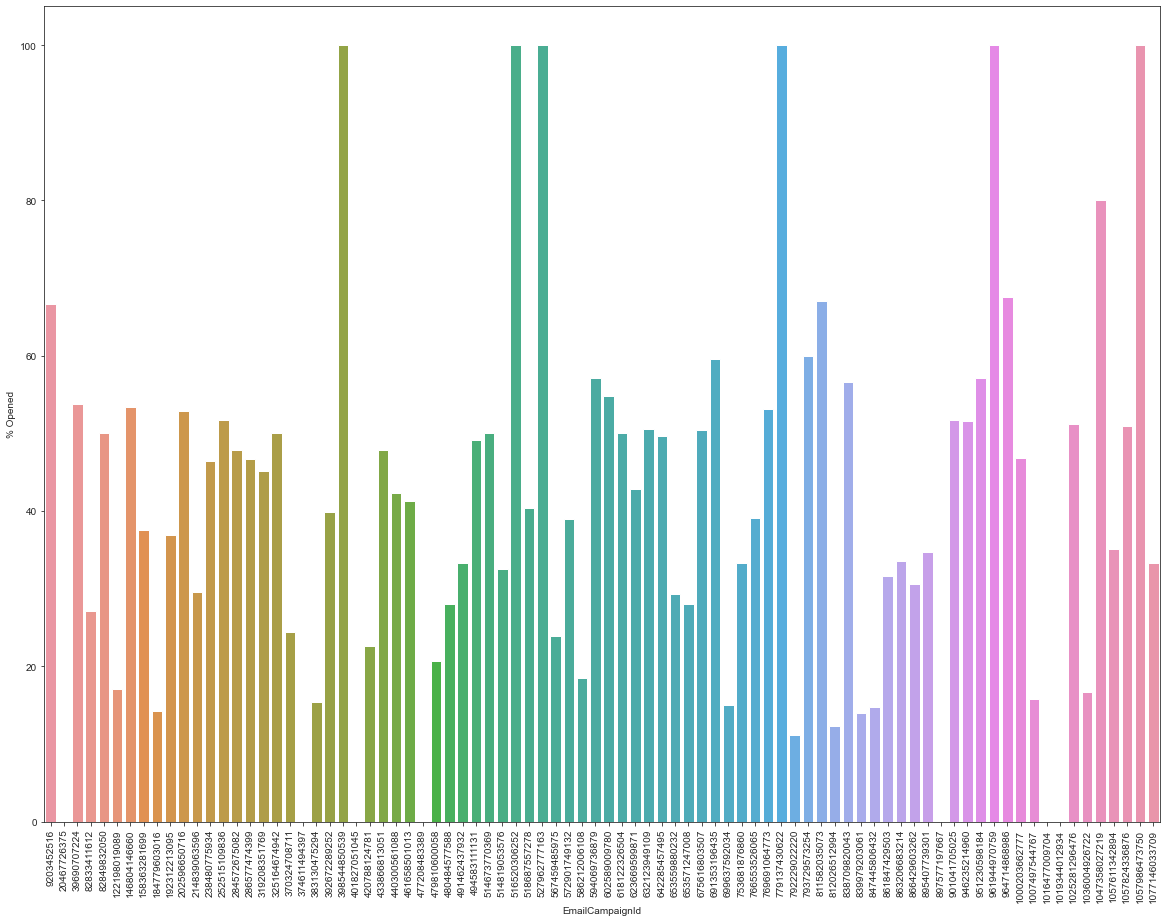

In [74]:
#plot graph of % opened performance
sns.set_style('ticks')
fig = plt.figure(figsize = (20,15))
fig = sns.barplot(x = campaign_emails.index, y = campaign_emails['% Opened']);
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);

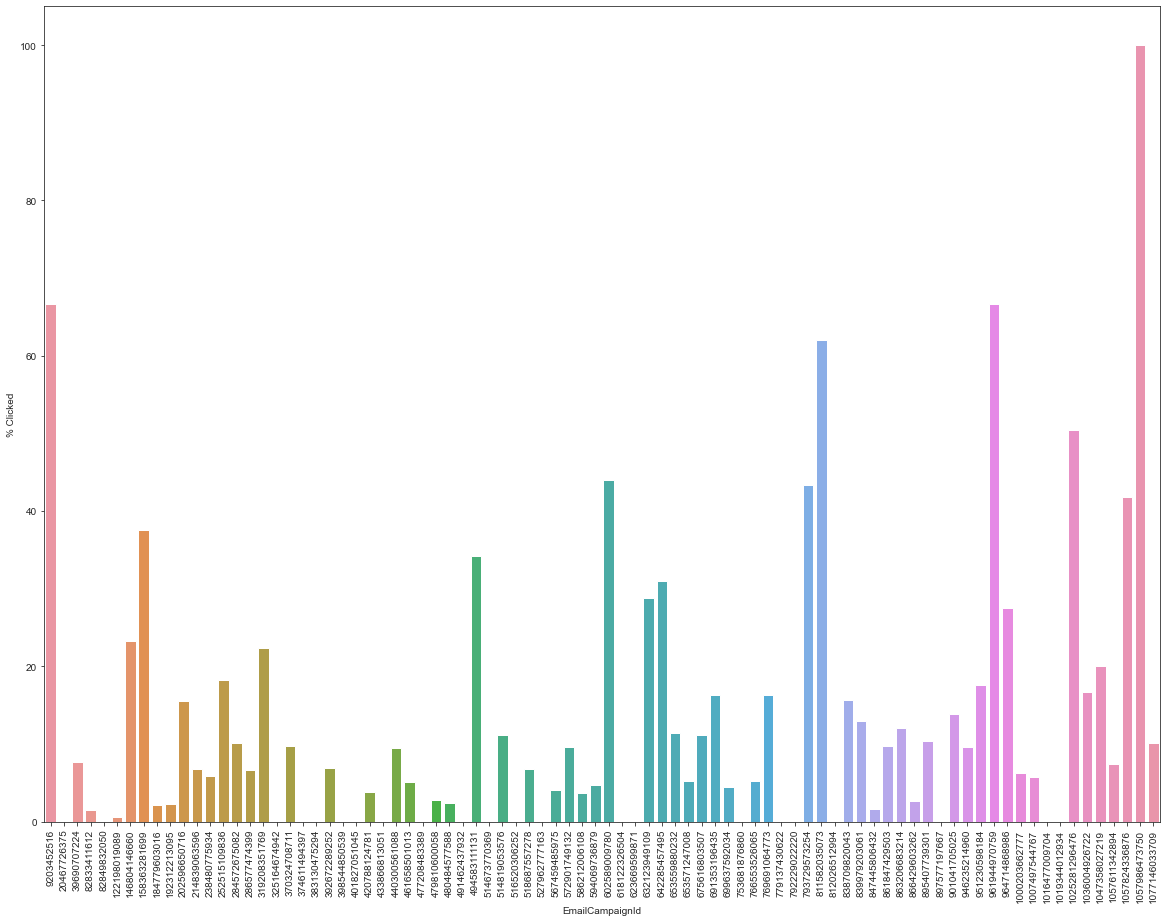

In [75]:
#plot graph of % clicked performance
sns.set_style('ticks')
fig = plt.figure(figsize = (20,15))
fig = sns.barplot(campaign_emails.index, campaign_emails['% Clicked']);
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);

In [76]:
#assess the correlation between the % opened and % clicked (Understanding that this is across all email campaigns)

campaign_emails['% Opened'].corr(campaign_emails['% Clicked']) #shows a generally weak correlation 

0.4808226151728805

In [77]:
#some campaigns have only a few emails and show very high success rates but are difficult to assess given their small sample sizes, consider using the median value as a baseline minimum for campaign id counts 
limited_campaign_emails = campaign_emails[campaign_emails['EmailSentDateTimePST'] >= campaign_emails['EmailSentDateTimePST'].median()] 
limited_campaign_emails.head() 
campaign_emails['EmailSentDateTimePST'].median()#the median email count for campaigns is approximately 158 emails. 

158.5

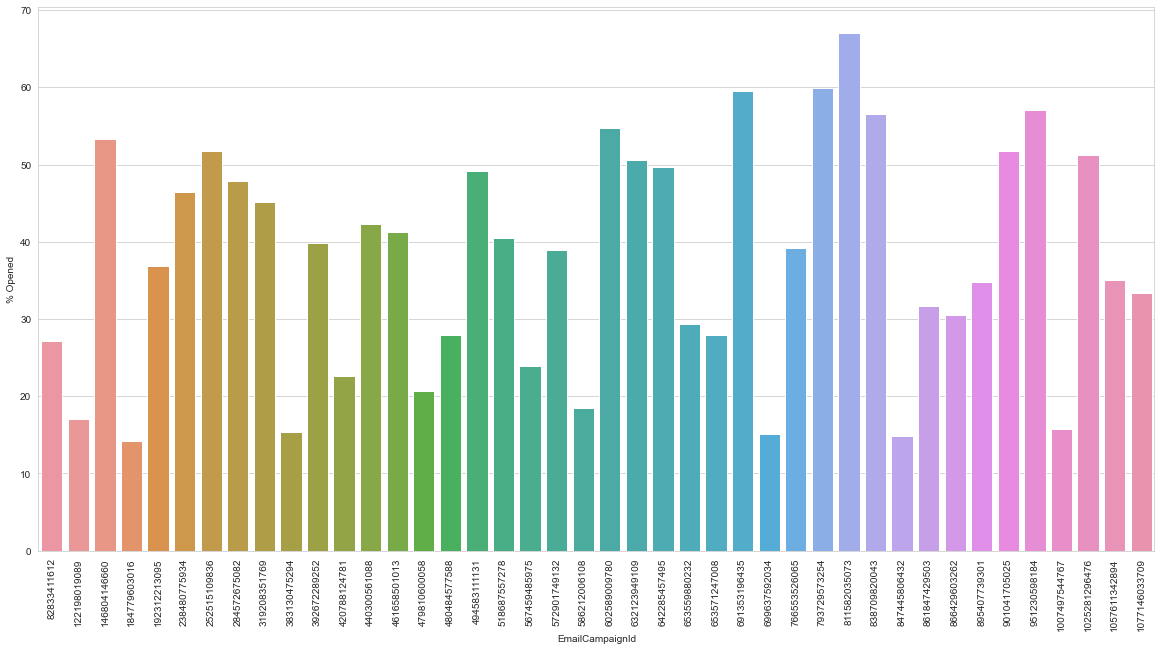

In [78]:
#plot the graph of the limited campaign email performance of opened emails 
sns.set_style('whitegrid')
fig = plt.figure(figsize = (20,10))
fig = sns.barplot(x = limited_campaign_emails.index, y = limited_campaign_emails['% Opened']);
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);

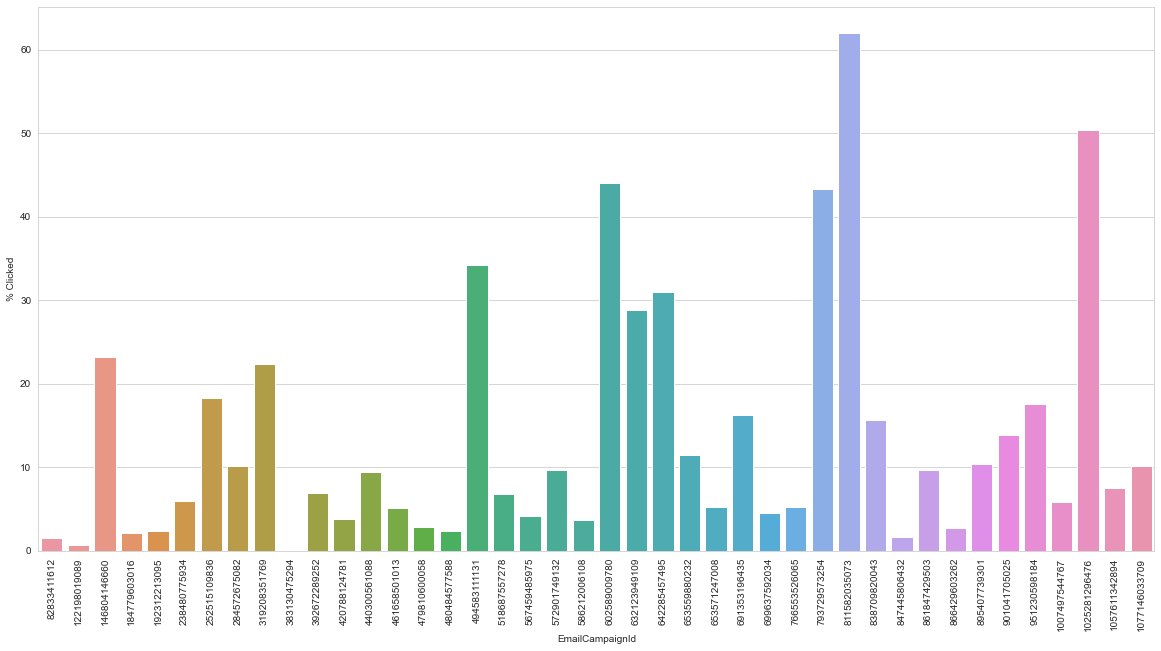

In [79]:
#plot the graph of the limited campaign email performance of clicked emails 
sns.set_style('whitegrid')
fig = plt.figure(figsize = (20,10))
fig = sns.barplot(x = limited_campaign_emails.index, y = limited_campaign_emails['% Clicked']);
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);

# Thoughts on analysis:

- Is there a minimum threshold that is required in order to determine which campaigns should be retained and which should be dropped? (i.e. successful campaign resides at 25%)
- Do campaigns that contain few emails (emails < median count value) but show high performance in clicks warrant investigation into renewed attempts? 
- Is there some commonality among emails that show high success rates (style/formating/target audience) that can be replicated to future campaigns? 


# #6b Does timing of email effect the emails performance? 

In [80]:
email_times = pd.read_csv('email_data.csv', header = 0, delimiter = ',') #reimport data

In [81]:
def pac_times(df, column): #create simliar function as before however, this function does not call for converting to date format and leaves the datetime object as is
    df[column] = pd.to_datetime(df[column])
    df[column] = df[column].dt.tz_localize('UTC')
    df[column] = df[column].dt.tz_convert('US/Pacific')

    df.rename(columns = {column:column.replace('Utc', 'PST')}, inplace = True)
    

time_cols = ['EmailSentDateTimeUtc', 'EmailOpenedDateTimeUtc', 'EmailClickedDateTimeUtc']

for column in time_cols: #apply function to all columns
    pac_times(email_times, column)

In [82]:
seasonal_rates = email_times.groupby(email_times['EmailSentDateTimePST'].dt.month).count()[['EmailSentDateTimePST', 'EmailOpenedDateTimePST', 'EmailClickedDateTimePST']] #segregate and group dataset by month to assess seasonal changes
day_of_week_rates = email_times.groupby(email_times['EmailSentDateTimePST'].dt.day_name()).count()[['EmailSentDateTimePST', 'EmailOpenedDateTimePST', 'EmailClickedDateTimePST']] #segregate and group dataset by day of week to consider weekend changes
hour_rates = email_times.groupby(email_times['EmailSentDateTimePST'].dt.hour).count()[['EmailSentDateTimePST', 'EmailOpenedDateTimePST', 'EmailClickedDateTimePST']] #segregate and group dataset by hour to consider time of day changes 

In [83]:
#create performance measures for each of the grouped timings for opened and clicked rates
seasonal_rates['% Opened'] = (seasonal_rates['EmailOpenedDateTimePST'] / seasonal_rates['EmailSentDateTimePST']) * 100
seasonal_rates['% Clicked'] = (seasonal_rates['EmailClickedDateTimePST'] / seasonal_rates['EmailSentDateTimePST']) * 100

day_of_week_rates['% Opened'] = (day_of_week_rates['EmailClickedDateTimePST'] / day_of_week_rates['EmailSentDateTimePST']) * 100
day_of_week_rates['% Clicked'] = (day_of_week_rates['EmailClickedDateTimePST'] / day_of_week_rates['EmailSentDateTimePST']) * 100

hour_rates['% Opened'] = (hour_rates['EmailOpenedDateTimePST'] / hour_rates['EmailSentDateTimePST']) * 100
hour_rates['% Clicked'] = (hour_rates['EmailClickedDateTimePST'] / hour_rates['EmailSentDateTimePST']) * 100

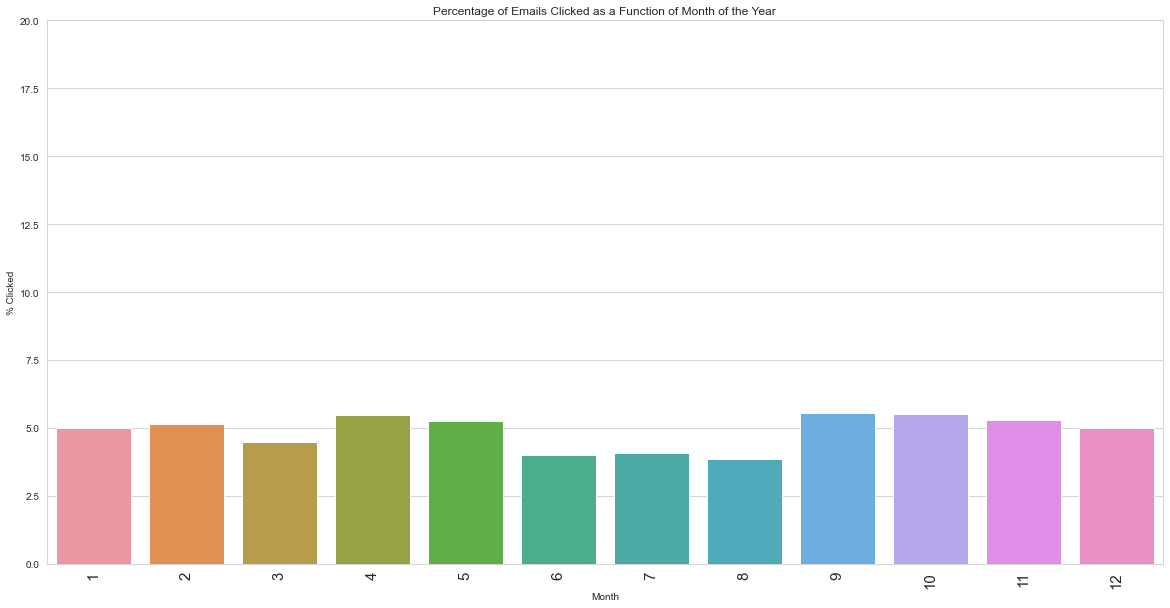

In [84]:
#plot performance measures of seasonal rates for clicked emails
sns.set_style('whitegrid')
fig = plt.figure(figsize = (20,10))
fig = sns.barplot(x = seasonal_rates.index, y = seasonal_rates['% Clicked'])
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize=15);
fig.set(xlabel = 'Month');
plt.ylim(0,20)
fig.set(title = 'Percentage of Emails Clicked as a Function of Month of the Year');

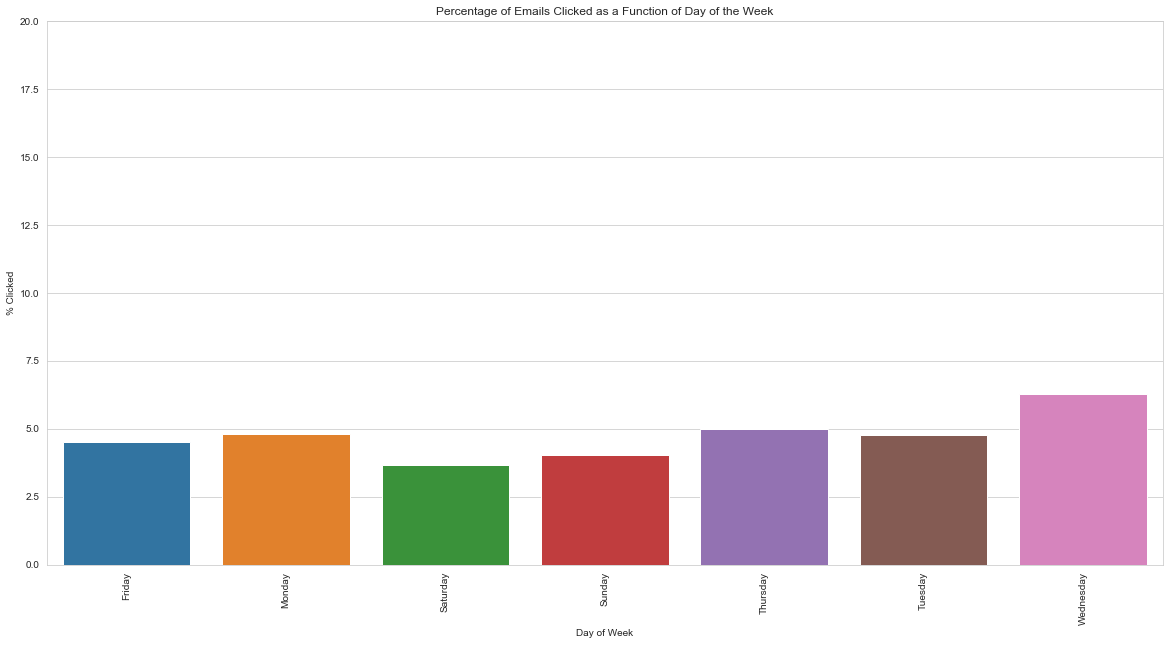

In [85]:
#plot performance measures of day of week rates for clicked emails
sns.set_style('whitegrid')
fig = plt.figure(figsize = (20,10))
fig = sns.barplot(x = day_of_week_rates.index, y = day_of_week_rates['% Clicked'])
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);
fig.set(xlabel = 'Day of Week');
plt.ylim(0,20)
fig.set(title = 'Percentage of Emails Clicked as a Function of Day of the Week');

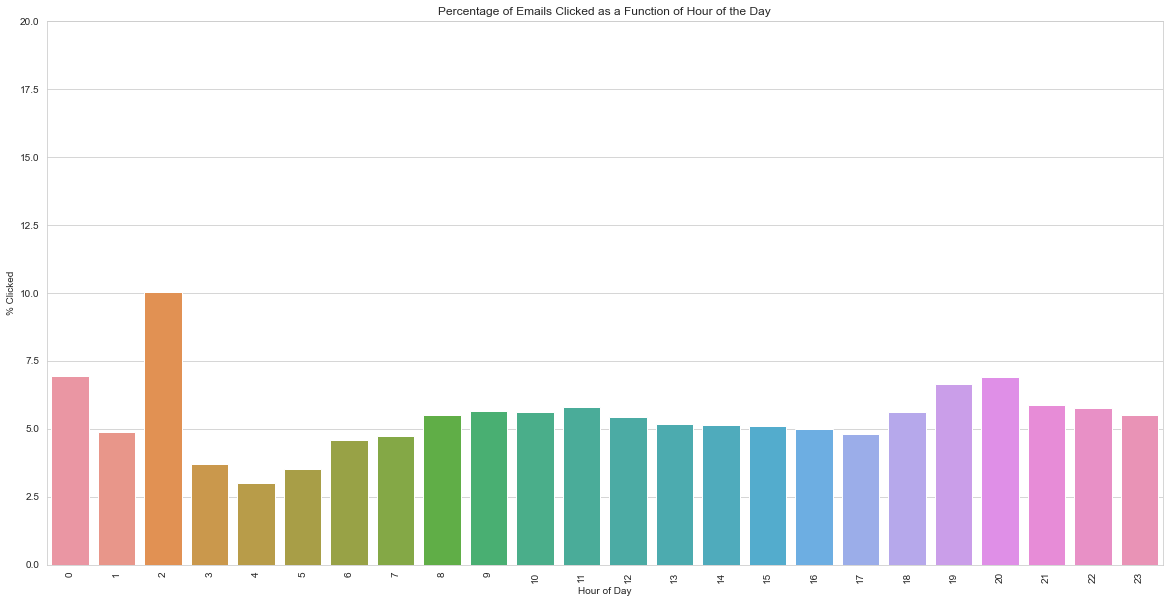

In [86]:
#plot performance measures of hour of day for clicked emails
sns.set_style('whitegrid')
fig = plt.figure(figsize = (20,10))
fig = sns.barplot(x = hour_rates.index, y = hour_rates['% Clicked'])
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);
fig.set(xlabel = 'Hour of Day');
plt.ylim(0,20)
fig.set(title = 'Percentage of Emails Clicked as a Function of Hour of the Day');

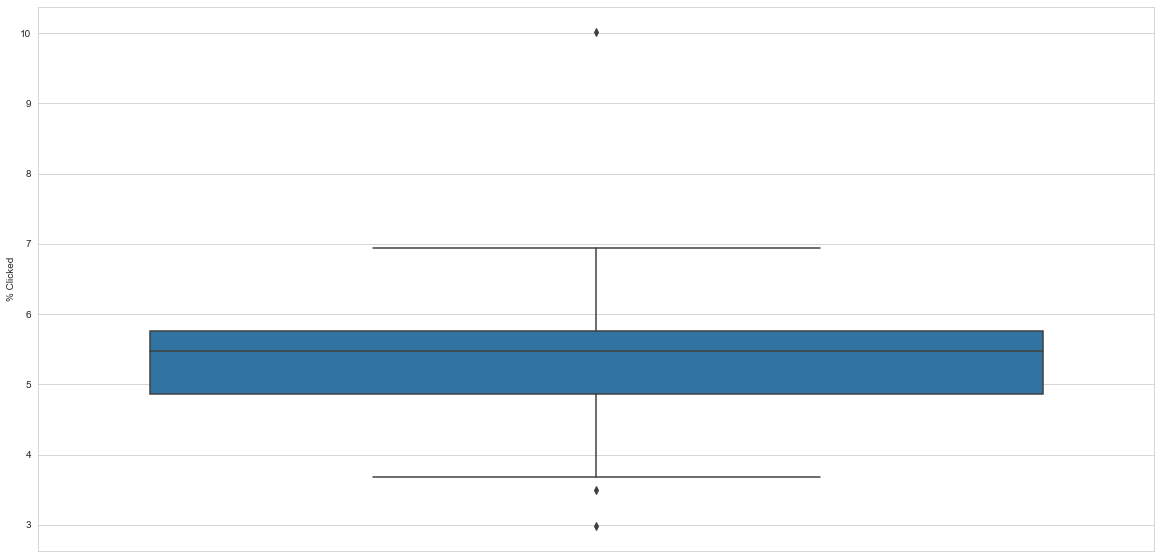

In [87]:
sns.boxplot(y = hour_rates['% Clicked']) #boxplot shows outliers for 10%, 3% and 3.5% that may warrant further investigation. Consider an ANOVA?

In [88]:
email = pd.read_csv('email_data.csv') #reimport email to reset time data

for col in time_cols:
    pac_time(email, col)


In [89]:
#At this point it may also be beneficial to consider how timing may effect the performance of user log in activity in addition to email open and click, however note that activity counts hold only daily resolution, not time of day

In [90]:
email['EmailSentDatePST'] = pd.to_datetime(email['EmailSentDateTimePST']).dt.date #convert to date time
email['EmailSentDatePST'] = email['EmailSentDatePST'].astype(str) #convert to string for future manipulation

In [91]:
activity['DateOfActivityPST'] = activity['DateOfActivityPST'].apply(str.strip) #remove whitespace to avoid joining errors

In [92]:
date_join = pd.merge(email, activity, left_on = ['UserId', 'EmailSentDatePST'], right_on = ['UserId', 'DateOfActivityPST'], how = 'left').groupby('EmailCampaignId').count() #join dataframes to assess days in which emails were sent and no activity recorded

In [93]:
date_join = date_join.drop(['EmailSentDateTimePST', 'UserId', 'ZipCode', 'AddressData', 'ActivityCount'], axis = 1) #remove extranneous columns

In [94]:
date_join['% Performance'] = (date_join['DateOfActivityPST'] / date_join['LogId']) * 100 #create performance metric column
date_join_slim = date_join[date_join['LogId'] >= date_join['LogId'].median()]  #reduce the counts down campaigns holding more than 50% of email counts

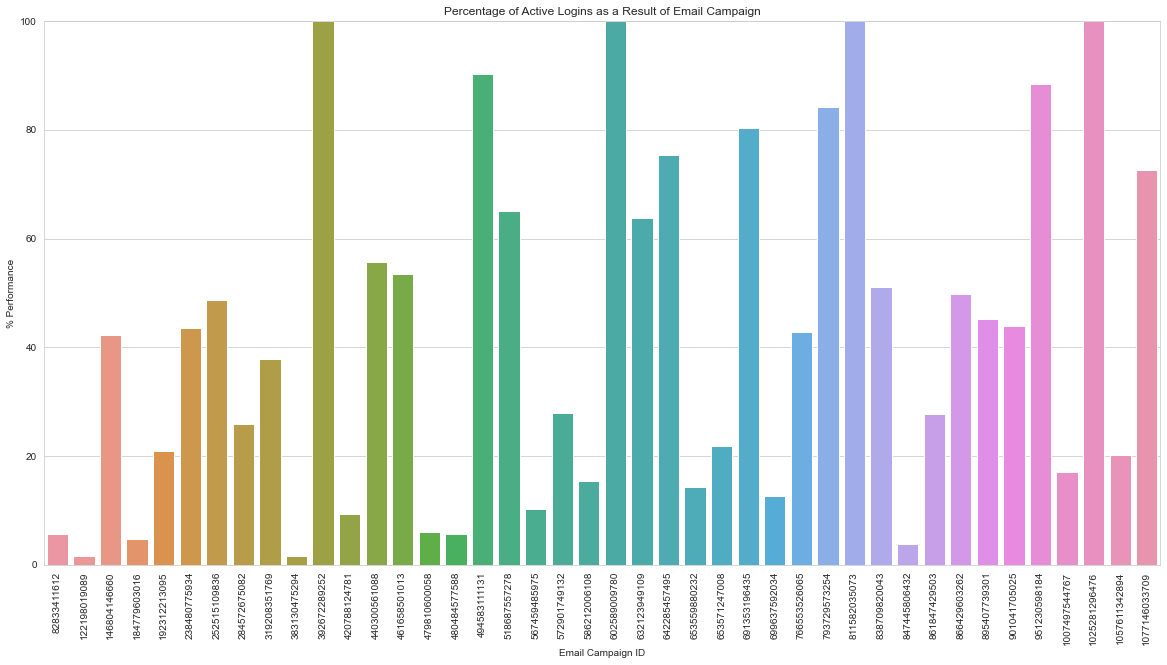

In [95]:
#plot performance of activity log ins vs. emails sent in each campaign
sns.set_style('whitegrid')
fig = plt.figure(figsize = (20,10))
fig = sns.barplot(x = date_join_slim.index, y = date_join_slim['% Performance'])
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);
fig.set(xlabel = 'Email Campaign ID');
plt.ylim(0,100)
fig.set(title = 'Percentage of Active Logins as a Result of Email Campaign');

In [96]:
#Assess whether log activity increases seasonally

email['EmailSentDatePST'] = pd.to_datetime(email['EmailSentDateTimePST'])
email['EmailSentDatePST'] = email['EmailSentDatePST'].astype(str)

active_times = pd.merge(email, activity, left_on = ['UserId', 'EmailSentDatePST'], right_on = ['UserId', 'DateOfActivityPST'], how = 'left')
active_times = active_times.drop(['ZipCode', 'AddressData', 'ActivityCount'], axis = 1)


In [97]:
active_times['EmailSentDateTimePST'] = pd.to_datetime(active_times['EmailSentDateTimePST']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific') #convert to PST

In [98]:
monthly_actives = active_times.groupby(active_times['EmailSentDateTimePST'].dt.month).count() #get a count of how activity changes on a month by month basis

In [99]:
monthly_actives['% Performance'] = (monthly_actives['DateOfActivityPST'] / monthly_actives['LogId']) * 100 #create performance metric
monthly_actives

,LogId,EmailSentDateTimePST,EmailCampaignId,EmailOpenedDateTimePST,EmailClickedDateTimePST,UserId,EmailSentDatePST,DateOfActivityPST,% Performance
EmailSentDateTimePST,,,,,,,,,
1,43909,43909,43909,12560,2172,43909,43909,8640,19.677059
2,42358,42358,42358,12672,2163,42358,42358,8646,20.411729
3,59777,59777,59777,17845,2727,59777,59777,10436,17.458220
4,45208,45208,45208,14349,2538,45208,45208,9658,21.363475
5,37743,37743,37743,11510,1942,37743,37743,7814,20.703177
6,38369,38369,38369,10435,1567,38369,38369,6079,15.843520
7,30016,30016,30016,8699,1180,30016,30016,4483,14.935368
8,31828,31828,31828,9170,1234,31828,31828,5063,15.907377
9,33457,33457,33457,9850,1857,33457,33457,6774,20.246884


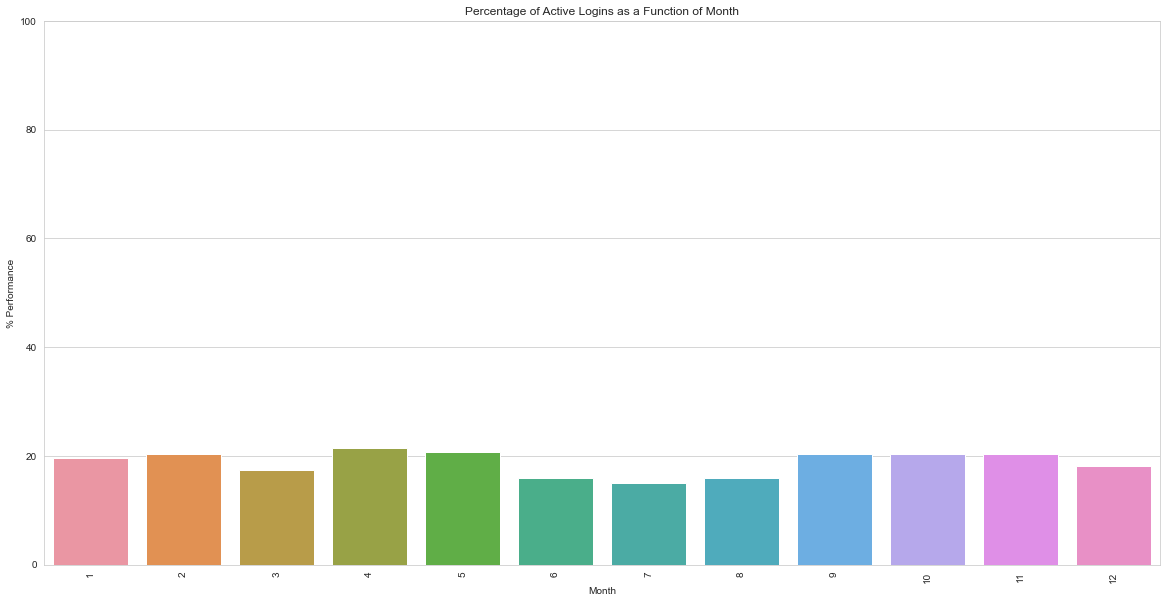

In [100]:
#plot activity performance over month as a function of emails sent
sns.set_style('whitegrid')
fig = plt.figure(figsize = (20,10))
fig = sns.barplot(x = monthly_actives.index, y = monthly_actives['% Performance'])
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90);
fig.set(xlabel = 'Month');
plt.ylim(0,100)
fig.set(title = 'Percentage of Active Logins as a Function of Month');

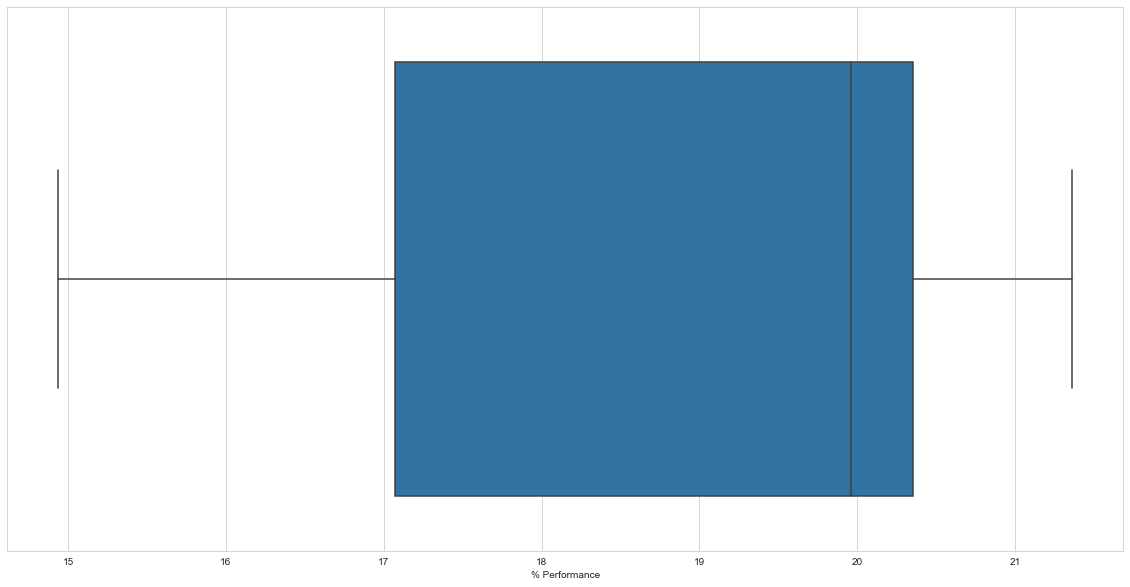

In [101]:
sns.boxplot(x = monthly_actives['% Performance']) #no outliers observed from boxplot representation

# #6 Summary

There are several email campaigns that show high performance in engaging users to either open or click on an email. Users are far more likely to open the email than to click when in the email, however 
the two values are not highly correlated.  It may be beneficial to establish a minimum threshold in which to deem an email campaign as effective or not given the resources required for each.  This may further
help to isolate effective campaigns and attempt to find commonality among them which can be imparted into future campaigns.campaign_emails

Some variation is seen in the time of day at which an email is sent.  An increase in success is observed when the email is sent at 2 a.m., however the performance reduces at subsequent hours of 3, 4, and 5 a.m. 
It is possible this is a random anomaly, but may warrant further investigation. No seasonal changes are observed in any group, including log-in activity. Performance measures overall appear to be generally independent of time.  



# #7 Assessing call to action buttons with A/B testing

In [102]:
email = pd.read_csv('email_data.csv', header = 0, delimiter = ',') #read in fresh data
campaign = email[(email['UserId'] >= 20000000) & (email['UserId'] <= 1000000000000)] #create subset of the data for users between 20000000 and  1000000000000

In [103]:
exp_group = campaign[campaign['UserId'] > 498689408027] #create experimental group
ctrl_group = campaign[campaign['UserId'] <= 498689408027] #create control group

In [104]:
len(exp_group)/ len(ctrl_group) #confirm that the data is appproximately evenly split

0.9998381966788713

In [105]:
#perform datetime manipulations, consider a function as done previously
exp_group = exp_group.copy()
exp_group['EmailSentDateTimeUtc'] = pd.to_datetime(exp_group['EmailSentDateTimeUtc']).dt.tz_localize('Utc').dt.tz_convert('US/Pacific').dt.date
exp_group['EmailOpenedDateTimeUtc'] = pd.to_datetime(exp_group['EmailOpenedDateTimeUtc']).dt.tz_localize('Utc').dt.tz_convert('US/Pacific').dt.date
exp_group['EmailClickedDateTimeUtc'] = pd.to_datetime(exp_group['EmailClickedDateTimeUtc']).dt.tz_localize('Utc').dt.tz_convert('US/Pacific').dt.date

In [106]:
ctrl_group = ctrl_group.copy()
ctrl_group['EmailSentDateTimeUtc'] = pd.to_datetime(ctrl_group['EmailSentDateTimeUtc']).dt.tz_localize('Utc').dt.tz_convert('US/Pacific').dt.date
ctrl_group['EmailOpenedDateTimeUtc'] = pd.to_datetime(ctrl_group['EmailOpenedDateTimeUtc']).dt.tz_localize('Utc').dt.tz_convert('US/Pacific').dt.date
ctrl_group['EmailClickedDateTimeUtc'] = pd.to_datetime(ctrl_group['EmailClickedDateTimeUtc']).dt.tz_localize('Utc').dt.tz_convert('US/Pacific').dt.date

In [107]:
email_counts_exp = exp_group.sort_values(by="EmailSentDateTimeUtc").groupby('EmailSentDateTimeUtc')['EmailSentDateTimeUtc'].count()#gives the count of emails sent for a given day for number of emails sent in the control group
email_counts_ctrl = ctrl_group.sort_values(by="EmailSentDateTimeUtc").groupby('EmailSentDateTimeUtc')['EmailSentDateTimeUtc'].count() #gives the count of emails sent for a given day for number of emails sent in the exp group

In [108]:
click_counts_exp = exp_group.sort_values(by="EmailSentDateTimeUtc").groupby('EmailSentDateTimeUtc')['EmailClickedDateTimeUtc'].count() #gives the count of emails clicked in the exp group
click_counts_ctrl = ctrl_group.sort_values(by="EmailSentDateTimeUtc").groupby('EmailSentDateTimeUtc')['EmailClickedDateTimeUtc'].count() #gives the count of emails clicked in the control group

In [109]:
probs_exp = (click_counts_exp / email_counts_exp) * 100 #create performance metrics for clicks and total emails in both the control and experimental group
probs_ctrl = (click_counts_ctrl / email_counts_ctrl) * 100

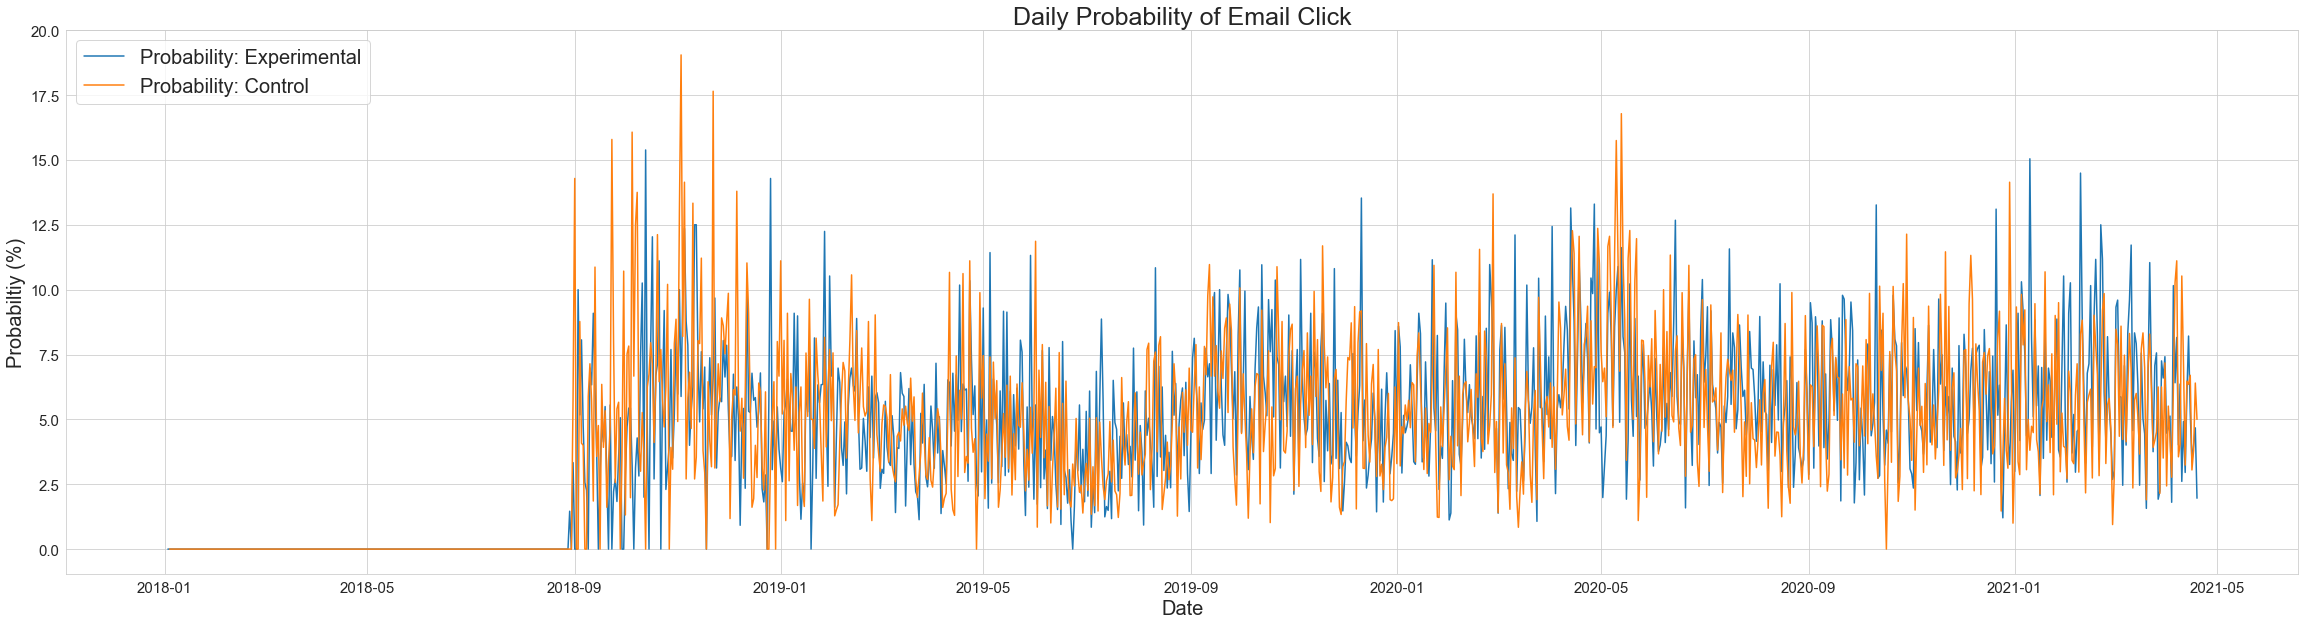

In [110]:
#plot the daily probability of control and experimental groups
fig = plt.figure(figsize = (40,10))
sns.lineplot(data = probs_exp)
sns.lineplot(data = probs_ctrl)
plt.title('Daily Probability of Email Click', fontsize = 25)
plt.ylabel('Probabiltiy (%)', fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.legend(labels=['Probability: Experimental', 'Probability: Control'], prop = {'size':20}, loc = 2, fontsize=15);

# #7 Summary

# Is this a good experimental design?

A few areas of concern are noted in the setup and design of the experiment.  The first is the means in which the populations are segmented.  Rather than choosing simple random samples, the users are arbitrarily split
based on their unique IDs, making their likelihood of falling into either group dependent on the origins of that ID.  If the user ID is in some way sequential, is there an inherent bias between users that arrived
at the app earlier vs. those who arrived later?  A better approach may be to randomly sample portions of the population and place them within the control and experimental groups.  Additionally as a means to better
represent the population, it may be beneficial to apply a simple random stratified approach, in which users may be categorized into sub units and randomly selected as better representatives of that population.  

A second concern is the interval in which probabilities are addressed.  Providing daily probability may not provide the best insight into long term trends and assessment of future likelihoods.  In an analogy, a basektball
player may shoot an over free throw percentage at 30% for a season, in which that larger time interval is a better true representation of his/her performance.  Future probabilities can be estimated based on this longer
time interval.  If that player were to shoot 10% on a single given day, and 60% on another given day, it is difficult to determine what their performance will be on another given day. Longer intervals allow for 
more representative and general trends to be more accurately estimated.  




# #8 Assess the efficacy of email campaigns on engaged and unengaged users:

Assumptions:
- Unengaged users are those with a 6 month period of inactivity as described in the activity log dataset)
- Engaged users are those who have recorded activity in the activity log and have no six month periods of inactivity across the dataset.


In [111]:
email= pd.read_csv('email_data.csv', header = 0, delimiter = ',') #read in fresh data and manipulate data into the proper time zone and string formatting 
email = email.astype(str)
    
for col in email.columns:
    email[col] = email[col].str.strip()

email['EmailSentDateTimeUtc'] = pd.to_datetime(email['EmailSentDateTimeUtc']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific').dt.date
email['EmailOpenedDateTimeUtc'] = pd.to_datetime(email['EmailOpenedDateTimeUtc']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific').dt.date
email['EmailClickedDateTimeUtc'] = pd.to_datetime(email['EmailClickedDateTimeUtc']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific').dt.date

activity = activity.astype(str)

for col in activity.columns:
    activity[col] = activity[col].str.strip()

activity['DateOfActivityPST'] = pd.to_datetime(activity['DateOfActivityPST']).dt.tz_localize('US/Pacific').dt.date

email_join = pd.merge(email, activity, left_on = ['UserId', 'EmailSentDateTimeUtc'], right_on = ['UserId', 'DateOfActivityPST'], how = "left").drop(['LogId', 'ZipCode', 'AddressData'], axis = 1)
email_join.head()

,EmailSentDateTimeUtc,EmailCampaignId,EmailOpenedDateTimeUtc,EmailClickedDateTimeUtc,UserId,DateOfActivityPST,ActivityCount
0,2019-07-31,792229022220,NaT,NaT,851332105693,NaN,NaN
1,2019-08-01,866429603262,2019-08-02,NaT,369293054977,NaN,NaN
2,2019-08-07,383130475294,NaT,NaT,938684493058,NaN,NaN
3,2019-08-07,792229022220,NaT,NaT,50233193142,NaN,NaN
4,2019-08-12,479810600058,NaT,NaT,369293054977,NaN,NaN


In [112]:
#determine if any users have never logged in and what %
inactive_counts = email_join.groupby('UserId').count()
unique_users = inactive_counts[inactive_counts['DateOfActivityPST'] == 0].shape[0] #get number of unique users that have recorded no log in activity
total_users = inactive_counts.shape[0] #get number of total users
perc = unique_users / total_users * 100 #determine percentage of users that have never logged in 

print(f'Percentage of users with no log-in activity: {perc:.1f}%.') # 72.5% of users have no recorded log in activity.

Percentage of users with no log-in activity: 72.5%.


In [113]:
email_join['DateOfActivityPST'] = pd.to_datetime(email_join['DateOfActivityPST']) #convert the activity dataset column to datetime 
#email_join = email_join.sort_values(by=['UserId', 'DateOfActivityPST'])
#email_join['Interval'] = email_join.groupby('UserId')['DateOfActivityPST'].apply(lambda group: group.ffill().diff()) #create dataframe that determines the interval of time between a user's log in 
#email_join.head()

In [114]:
email_join = email_join.sort_values(by=['UserId', 'DateOfActivityPST'], ascending = True)
email_join['LastLogIn'] = email_join.groupby(['UserId'])['DateOfActivityPST'].ffill().diff() #create a column that determines each unique users time intervals between logins.  This will act as the threshold in determining engaged and unengaged users

In [115]:
email_join[50:100] #confirm that the last login column is accurately checking dates and intervals 

,EmailSentDateTimeUtc,EmailCampaignId,EmailOpenedDateTimeUtc,EmailClickedDateTimeUtc,UserId,DateOfActivityPST,ActivityCount,LastLogIn
39721,2018-12-23,192312213095,2019-01-05,NaT,1000146758194,NaT,NaN,NaT
39722,2020-12-10,192312213095,NaT,NaT,1000146758194,NaT,NaN,NaT
39723,2020-03-12,82833411612,NaT,NaT,1000146758194,NaT,NaN,NaT
39724,2020-04-04,82833411612,NaT,NaT,1000146758194,NaT,NaN,NaT
249222,2019-07-27,192312213095,NaT,NaT,1000160615488,NaT,NaN,NaT
249223,2019-01-11,192312213095,NaT,NaT,1000160615488,NaT,NaN,NaT
249224,2018-11-22,192312213095,NaT,NaT,1000160615488,NaT,NaN,NaT
249225,2019-12-29,479810600058,NaT,NaT,1000160615488,NaT,NaN,NaT
465287,2021-01-22,479810600058,NaT,NaT,1000173374906,NaT,NaN,NaT
79456,2018-05-03,866429603262,NaT,NaT,1000182949519,2018-05-03,23,NaT


In [116]:
email_join['LastLogIn'] = email_join['LastLogIn'].dt.days #convert datetime to day counts in order to aggregate on
email_join['ActivityCount'] = email_join['ActivityCount'].astype(float) #convert to float from NaN as int is not a compatable NaN conversion

In [117]:
email_join['Flags'] = email_join['LastLogIn'].apply(lambda x: 1 if  x >= 180 else 0) #for each element within the interval column, create a flag category 'Flag' that flags if a user has a period of unengagement. Keeping these as 
#numeric values rather than alpha values will help in aggregation each user's count of inactive period

email_join[50:100] #confirm flags column and last login column are still performaing accurately

,EmailSentDateTimeUtc,EmailCampaignId,EmailOpenedDateTimeUtc,EmailClickedDateTimeUtc,UserId,DateOfActivityPST,ActivityCount,LastLogIn,Flags
39721,2018-12-23,192312213095,2019-01-05,NaT,1000146758194,NaT,NaN,NaN,0
39722,2020-12-10,192312213095,NaT,NaT,1000146758194,NaT,NaN,NaN,0
39723,2020-03-12,82833411612,NaT,NaT,1000146758194,NaT,NaN,NaN,0
39724,2020-04-04,82833411612,NaT,NaT,1000146758194,NaT,NaN,NaN,0
249222,2019-07-27,192312213095,NaT,NaT,1000160615488,NaT,NaN,NaN,0
249223,2019-01-11,192312213095,NaT,NaT,1000160615488,NaT,NaN,NaN,0
249224,2018-11-22,192312213095,NaT,NaT,1000160615488,NaT,NaN,NaN,0
249225,2019-12-29,479810600058,NaT,NaT,1000160615488,NaT,NaN,NaN,0
465287,2021-01-22,479810600058,NaT,NaT,1000173374906,NaT,NaN,NaN,0
79456,2018-05-03,866429603262,NaT,NaT,1000182949519,2018-05-03,23.0,NaN,0


In [118]:
#Create a result dataframe that holds all pertinent information and aggregations respective of their purposes. 
result =email_join.groupby('UserId').agg({'DateOfActivityPST':'count', 'EmailClickedDateTimeUtc':'count', 'EmailSentDateTimeUtc':'count', 'EmailOpenedDateTimeUtc':'count','ActivityCount':'sum', 'Flags':'sum'})
result = result.rename(columns = {'DateOfActivityPST': 'Active Days in Log (Count)', 'EmailClickedDateTimeUtc':'Email Clicked (Count)', 'EmailSentDateTimeUtc':'Emails Sent (Count)', 'EmailOpenedDateTimeUtc':'Emails Opened (Count)' ,'ActivityCount':'Activity (Sum)', 'Flags':'Unengaged Periods (Sum)'})

result.head() #result dataframe that contains ALL users, including those that never logged in and have no activity recorded over the span of the dataset

,Active Days in Log (Count),Email Clicked (Count),Emails Sent (Count),Emails Opened (Count),Activity (Sum),Unengaged Periods (Sum)
UserId,,,,,,
1000010442055,0,0,1,0,0.0,0
100002700264,0,0,4,0,0.0,0
1000030930111,0,0,3,0,0.0,0
1000031755163,0,0,3,0,0.0,0
1000048537753,0,0,1,1,0.0,0


In [119]:
result['Unengaged Periods (Sum)'].value_counts() #observe how many users have different numbers of periods of inactivity

0    98665
1     7161
2     1379
3      113
4        7
Name: Unengaged Periods (Sum), dtype: int64

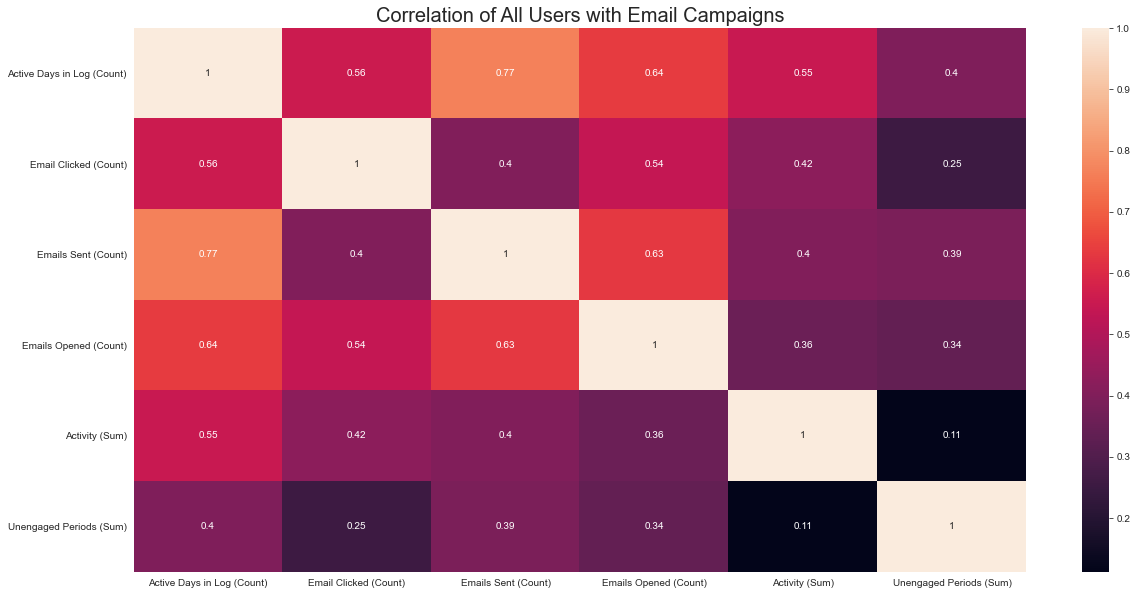

In [120]:
#Plot a heatmap in order to observe the correlations for all users relative to email campaign
sns.heatmap(result.corr(), annot= True) #heatmap for ALL users, including those who have never logged in
plt.yticks(rotation=0);
plt.title('Correlation of All Users with Email Campaigns', fontsize = 20);

The above plot shows the correlation values for all users across the dataset, including those that registered no activity or log-in information.  While some relationship information can be taken from this plot it
is likely more beneficial to remove users with no log in information, as they likely impart little information into the effectiveness of email campaigns. An additional investigation is performed in the heatmap below this cell in
and attempt to observe if there is any relationship between how those users open and/or click emails they receive.  

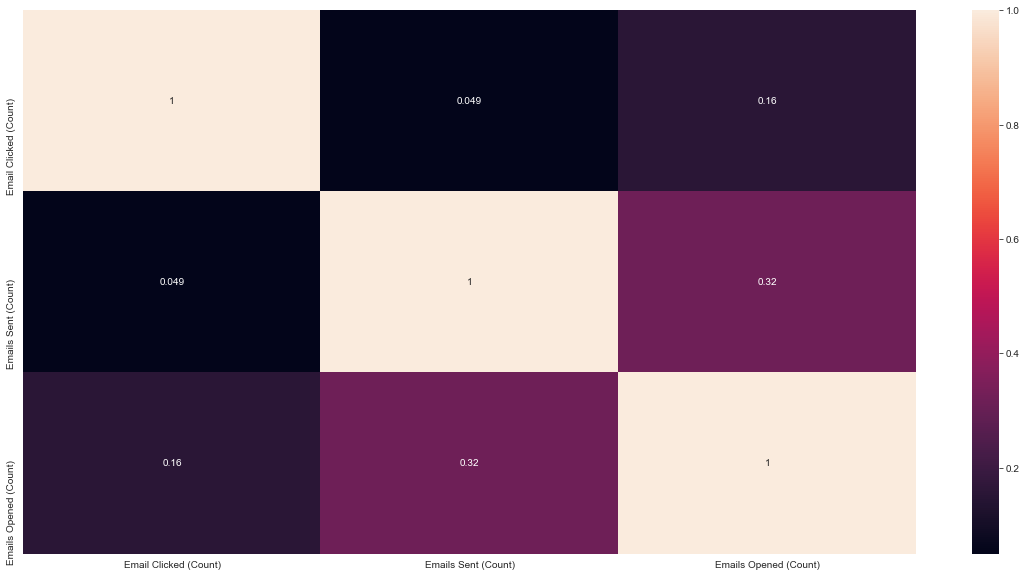

In [121]:
#Investigate the correlation between emails sent/clicked/opened for users who have never logged in
sns.heatmap(result[result['Active Days in Log (Count)'] == 0].drop(columns = ['Active Days in Log (Count)', 'Unengaged Periods (Sum)', 'Activity (Sum)'], axis = 1).corr(), annot=True);

The above plot highlights the correlations of users with no log in activity with their behaviors in response to email campaigns.  There appears to be no strong relationship between no-activity users and emails being opened or clicked.  This supports the notion that inactive users do not respond strongly to email campaigns.  

In [122]:
#Remove entirely unengaged users, i.e. users who never had activity and users with 0 unengaged periods, focusing on those who have never had a 6 month period of inactivity 
engaged = result[(result['Unengaged Periods (Sum)'] == 0) & (result['Active Days in Log (Count)'] > 0)].drop(['Unengaged Periods (Sum)'], axis = 1) #create only 'engaged users', that is, users who have no periods of 6 month 
#inactivity and who have recorded as least 1 log in in the activity log. 

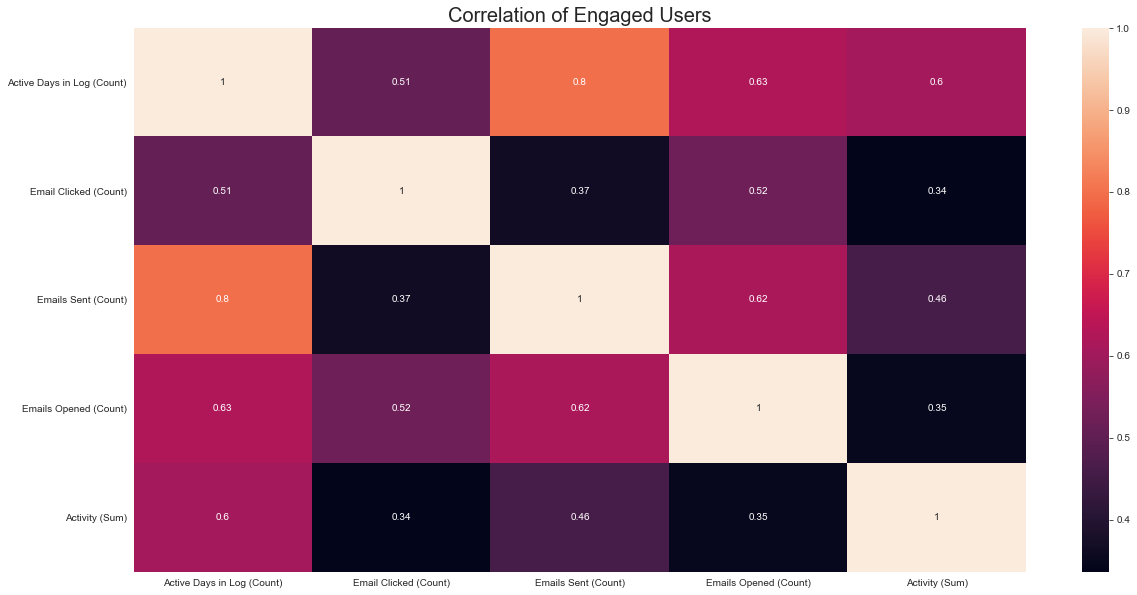

In [123]:
#Create a plot to highlight the correlations of engaged users and their behavior in response to email campaigns. 
sns.heatmap(engaged.corr(), annot=True) 
plt.title('Correlation of Engaged Users', fontsize = 20);

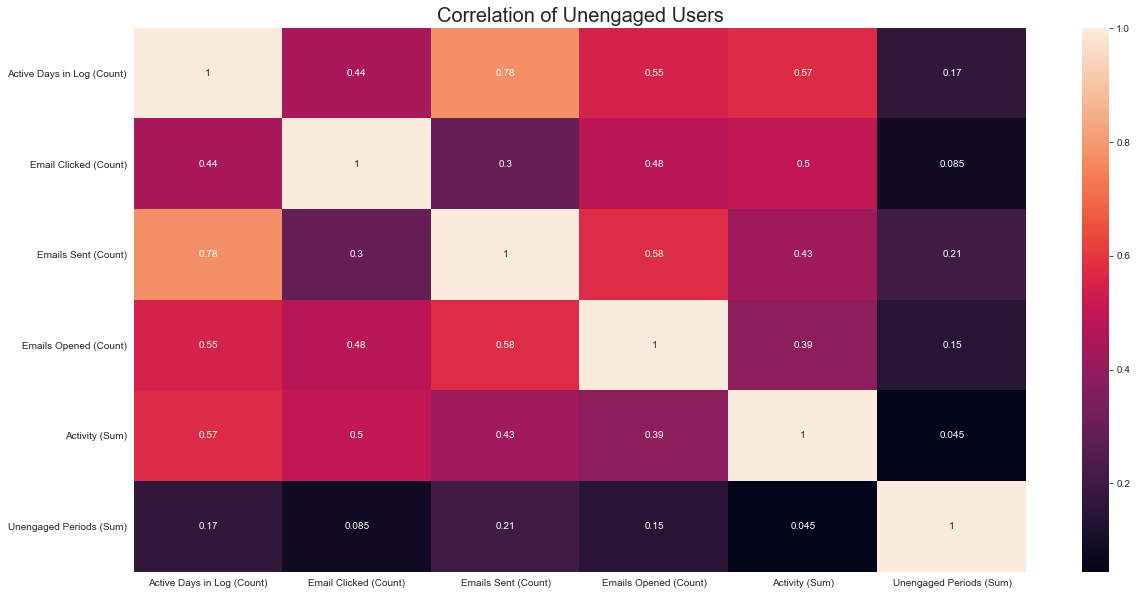

In [124]:
 #Segment the users that have periods of inactivity and have logged in at least once, these are defined as the unengaged users
unengaged = result[result['Unengaged Periods (Sum)'] > 0]#.drop(['Unengaged Periods (Sum)'],axis = 1)
sns.heatmap(unengaged.corr(), annot=True); #plot heatmap to see correlation between unengaged user activity and email tendency
plt.title('Correlation of Unengaged Users', fontsize = 20);

# #8 Summary:

For engaged users, the objective was to determine whether these users (those defined as users not having a 6-month period of inactivity) are positively influenced by email campaigns.  The correlation between the number of emails being sent to an engaged user and the number of days in which they are active on the app is high (0.80), which may suggest that higher volumes of email result in better campaign performance. However, this correlation does not signify causation. It is possible that the emails may be reminding or encouraging users to carry over to the app, but the weaker correlations between the number of emails sent, and the numbers of emails opened (0.62) and clicked (0.37), indicate the activity on the app is likely not a direct result from clicks stemming from sent emails.  At the same time it should be noted that these correlations are higher than those in the unengaged group, potentially suggesting there is at least some postiive influence on active users from email campaigns. The relationship between the number of emails sent and the magnitude of app activity by that user is only moderately correlated (0.46) and shows activity levels are not strongly influenced by email campaigns. The overall evidence suggests that engaged users may be active regardless of email campaigns, and while some users may be influenced or encouraged to log in to the app through the presence of email, the relationship cannot be defined as a cause of performance success.    

For unengaged users, the objective was to determine whether these users (those defined as having at least one 6 month period of inactivity) are influenced by email campaigns in any fashion.  The hypothesis is that more email counts would lead to less periods of inactivity, however no relationship is observed between the number of emails sent to unengaged users, and the number of periods of inactivity they report.  Similar to engaged users, the numbers of email sent highly correlates (0.78) with the number of active days on the app. The values of email opening and clicks follow a similar pattern of the engaged group, albeit with less magnitude. There appears to be no correlation with the number of periods of inactivity with the number of emails sent, clicked, opened, or the level of activity logged on the app.  This evidence suggests that unengaged users may still log in, however there is no clear relationship to suggest that higher volumes of emails will promote better campaign performance among unengaged users.  

(As an aside, it was checked to see if the number of inactive periods played a role in the likelihood in which a user is receptive to email campaigns.  Limited sample size of users with more than 2 inactive periods proved difficult to assess these relationships, but may warrant investigation in the future with more data.)
